# Traffic Sign Detection


## Introduction to challenge
We have decided to take a dataset from Kaggle ([Arabic Handwritten Characters Dataset](https://www.kaggle.com/mloey1/ahcd1)) for this challenge.   

- 16,800 characters written by 60 participants
- Each participant wrote each character (from ’alef’ to ’yeh’) ten times on two forms 
- The forms were scanned at the resolution of 300 dpi. Each block is segmented automatically using Matlab 2016a to determining the coordinates for each block. 
- The database is partitioned into two sets: a training set (13,440 characters to 480 images per class) and a test set (3,360 characters to 120 images per class).
- Writers of training set and test set are exclusive. Ordering of including writers to test set are randomized to make sure that writers of test set are not from a single institution (to ensure variability of the test set).

__Acknowledgements__:

- A. El-Sawy, M. Loey, and H. EL-Bakry, “Arabic handwritten characters recognition using convolutional neural network,” WSEAS Transactions on Computer Research, vol. 5, pp. 11–19, 2017. 
https://doi.org/10.1007/978-3-319-48308-5_54
https://link.springer.com/chapter/10.1007/978-3-319-48308-5_54

- A. El-Sawy, H. EL-Bakry, and M. Loey, “CNN for handwritten arabic digits recognition based on lenet-5,” in Proceedings of the International Conference on Advanced Intelligent Systems and Informatics 2016, vol. 533, pp. 566–575, Springer International Publishing, 2016.
https://www.wseas.org/multimedia/journals/computerresearch/2017/a045818-075.php

- Loey, Mohamed, Ahmed El-Sawy, and Hazem El-Bakry. "Deep learning autoencoder approach for handwritten arabic digits recognition." arXiv preprint arXiv:1706.06720 (2017).
https://arxiv.org/abs/1706.06720

## Data Import
Uncomment and adapt path. 

In [1]:
#from google.colab import files
#uploaded = files.upload()
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))
## Then move kaggle.json into the folder where the API expects to find it.
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
## Path to file - reminder
##path_to_data = '/content/drive/MyDrive/DeepLearningVisionHSLU/DLV03_Project/data/images/'
### Linux commands for data manipulation
#!kaggle datasets download -d 'mloey1/ahcd1'
#!mv ./*.zip /content/drive/MyDrive/DeepLearningInVisionHSLU/
#!unzip -q /content/drive/MyDrive/DeepLearningInVisionHSLU/*.zip -d /content/drive/MyDrive/DeepLearningInVisionHSLU/
#!rm /content/drive/MyDrive/DeepLearningInVisionHSLU/*.zip

## Imports

In [2]:
# Built-in imports
import os, datetime, pathlib, random 
import math
from math import ceil, floor

# Basic imports
import numpy as np
import pandas as pd   

# Ploting libraries
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

import seaborn as sns
sns.set(color_codes=True)

import PIL.Image
import PIL
from PIL import Image
import skimage
from skimage import color, io
#from skimage import data
from skimage import transform

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard 

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.metrics import 

# Train-test-split and evaluation imports
from sklearn.model_selection import train_test_split # If required
from sklearn import metrics # classification report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

## Definitions

In [13]:
# Divides the input array into chunks of letters
def row_calculator(number_of_images, number_of_columns):
    if number_of_images % number_of_columns != 0:
        return (number_of_images / number_of_columns)+1
    else:
        return (number_of_images / number_of_columns)

# Display images by size and number of plots
def display_image(x, img_size, number_of_images):
    # Standard plot size
    plt.figure(figsize = (16, 9))
    # Takes only images 
    if x.shape[0] > 0:
        n_samples = x.shape[0]
        x = x.reshape(n_samples, img_size, img_size)
        number_of_rows = row_calculator(number_of_images, 4)
        for i in range(number_of_images):
            plt.subplot(number_of_rows, 4, i+1)
            plt.imshow(x[i])

# Show content of dictionary
def get_dir_content(path):
  return os.listdir(path)


# load image
def load_img(path):
  return io.imread(path)

# Show image
def show_image(image, title='Image',cmap_type='gray'):
  plt.imshow(image, cmap=cmap_type)
  plt.title(title)
  plt.axis('off')
  plt.show()

# Get size of images
def get_shape(img_array):
  return np.shape(img_array)

# Convert img to grayscale
def to_grayscale(img_array):
  grayscale = color.rgb2gray(img_array)
  grayscale *= 255
  return grayscale#.astype(np.uint8)

# Save new image
def save_new_img(img_array, filename, img_path, n):
  io.imsave(str(img_path).replace(filename, filename + f'__c_{n}'), img_array)

# Flip image left-right
def flip_lr(img_array):
  return np.fliplr(img_array)

# Flip image up-side-down
def flip_ud(img_array):
  return np.flipud(img_array)

# Warp image 
def warping(img_array):
  tform = transform.SimilarityTransform(
      scale=1, 
      rotation=0,
      translation=(
          np.random.normal(0,img_array.shape[0]/4),
          np.random.normal(0,img_array.shape[1]/4))
      )
  return transform.warp(img_array,tform)

# Rotate image
def rotate(img_array):
  return transform.rotate(img_array, np.random.normal(0,40))


## Pre-Processing


## Load data and labels

The train Images csv has 1024 columns and 13440 rows. Each column represents a pixel in an image and each row represents an individual grayscale images.

The value of each pixel varies from 0 -255.

Each column 

In [14]:
# Path to project
path_project_dir = pathlib.Path('/content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/')
# Path to data 
path_to_data = path_project_dir.parent / 'Arabic Handwritten Characters Dataset CSV' # because of github, this folder has been moved to the parent directory. 

# Load train/test data
train_data = pd.read_csv(path_to_data.joinpath('csvTrainImages 13440x1024.csv'),header = None)
test_data = pd.read_csv(path_to_data.joinpath('csvTestImages 3360x1024.csv'),header = None)
# Load train/test labels
train_label = pd.read_csv(path_to_data.joinpath('csvTrainLabel 13440x1.csv'),header = None)#.rename(columns={0:'label'})
test_label = pd.read_csv(path_to_data.joinpath('csvTestLabel 3360x1.csv'),header = None)#.rename(columns={0:'label'})

## Check set
print('='*20)
print('Training data info')
print('='*20)
print(train_data.info(),'\n')
print('\n')
print('='*20)
print('Training labels info')
print('='*20)
print(train_label.info(),'\n')

print('='*20)
print('Test data info')
print('='*20)
print(test_data.info(),'\n')
print('\n')
print('='*20)
print('Test labels info')
print('='*20)
print(test_label.info(),'\n')
print('='*20)

Training data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 105.0 MB
None 



Training labels info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       13440 non-null  int64
dtypes: int64(1)
memory usage: 105.1 KB
None 

Test data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 26.3 MB
None 



Test labels info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       3360 non-null   int64
dtypes: int64(1)
memory usage: 26.4 KB
None 



In [39]:
print(train_data.shape)
print(train_data.shape[0])

(13440, 1024)
13440


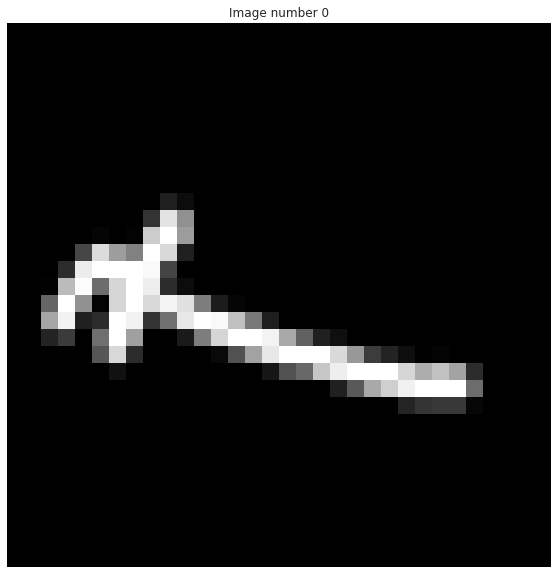

In [49]:
for i in range(0,train_data.shape[0],32):
  show_image(
    np.reshape(
        train_data.iloc[i,:].values.astype('float32'),
        (32,32),
    ), title=f'Image number {i}'
  )
  break

The database is partitioned into two sets: 
- Training set (13,440 characters to 480 images per class) => 28 Characters
- Test set (3,360 characters to 120 images per class) => 28 Characters

In [48]:
train_label

,0
0,1
1,1
2,1
3,1
4,1
...,...
13435,28
13436,28
13437,28
13438,28


In [ ]:
train_label[0].value_counts()

In [7]:
len(train_data.columns)

1024

In [8]:
print('Training:')
print(f'The shape of the df is: {train_data.shape}')
print(f'The meaning is: {train_data.shape[0]} letters divided in 28 categories with a (flatten) shape of {train_data.shape[1]} (32x32) pixels.')
print('='*50)
print('Test:')
print(f'The shape of the df is: {test_data.shape}')
print(f'The meaning is: {test_data.shape[0]} letters divided in 28 categories with a (flatten) shape of {train_data.shape[1]} (32x32) pixels.')

Training:
The shape of the df is: (13440, 1024)
The meaning is: 13440 letters divided in 28 categories with a (flatten) shape of 1024 (32x32) pixels.
Test:
The shape of the df is: (3360, 1024)
The meaning is: 3360 letters divided in 28 categories with a (flatten) shape of 1024 (32x32) pixels.


In [7]:
# Convert images to float32
train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1

test_data = test_data.iloc[:,:].values.astype('float32')
test_label = test_label.iloc[:,:].values.astype('int32')-1

### Show: Sample of training images

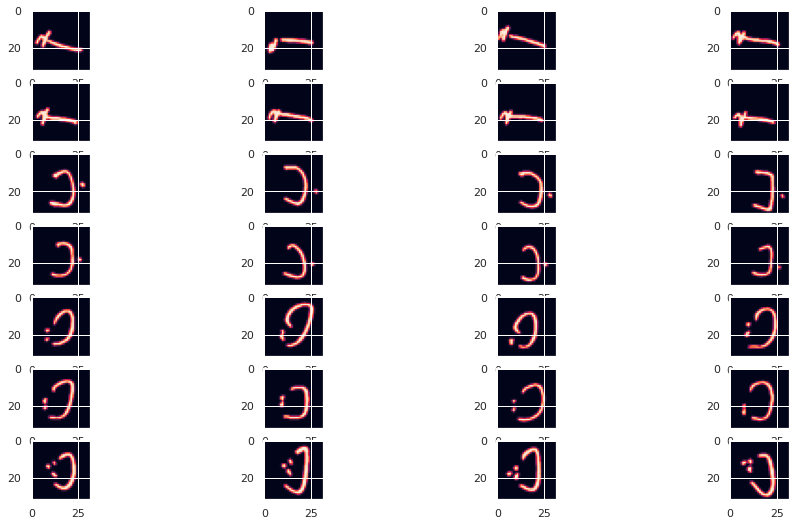

In [25]:
# Ten images 
display_image(train_data, 32, 28)

### Show: Sample of test images

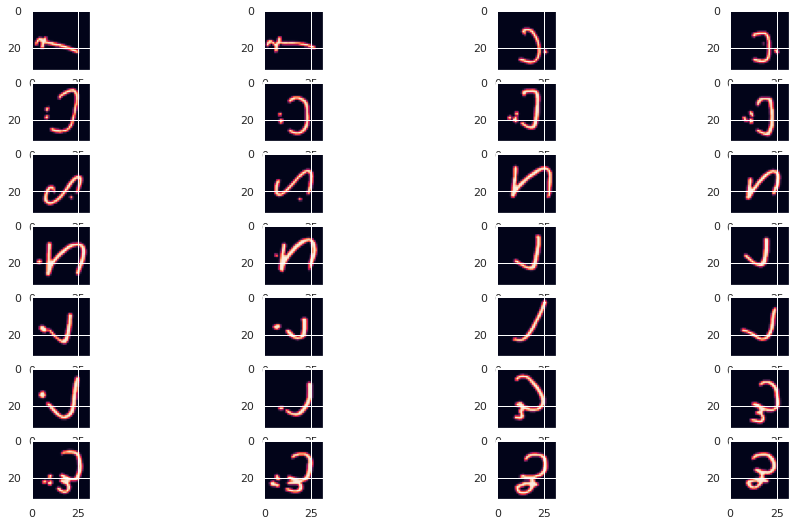

In [26]:
display_image(test_data, 32, 28)

### Shape check

In [27]:
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(13440, 1024) (13440, 1)
(3360, 1024) (3360, 1)


### Normalization, zero-centering, categorical transformations

In [28]:
# Normalization [0,255] -> [0,1]
train_data = train_data/255
test_data = test_data/255

# Reshape to 2D -> #, height, width, rgb
train_data = train_data.reshape([-1, 32, 32, 1])
test_data = test_data.reshape([-1, 32, 32, 1])

# Categorical variable
train_label = tf.keras.utils.to_categorical(train_label,28)
test_label = tf.keras.utils.to_categorical(test_label,28)

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(13440, 32, 32, 1) (13440, 28)
(3360, 32, 32, 1) (3360, 28)


### ImageDataGenerator: 
Generate batches of tensor image data with real-time data augmentation. This data is looped over in batches. Basically, It is used to load the images in batches.

In [29]:
validation_split = 0.2 

datagen = ImageDataGenerator(
    validation_split = validation_split,
    featurewise_center=False, 
    samplewise_center=False,  
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,  
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)


## Model 1) 
[CONV2D - CONV2D - MAXPOOL - DROPOUT] [CONV2D - CONV2D - MAXPOOL - DROPOUT] [DENSE - DENSE - DROPOUT]

### Architecture

In [42]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_1 = tf.keras.Sequential()

model_1.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', input_shape = (image_size, image_size, 1)))
model_1.add(tf.keras.layers.Activation('relu'))
model_1.add(tf.keras.layers.Conv2D(32, (5, 5))) # padding='same'? 
model_1.add(tf.keras.layers.Activation('relu'))
model_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_1.add(tf.keras.layers.Dropout(0.25))

model_1.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
model_1.add(tf.keras.layers.Activation('relu'))
model_1.add(tf.keras.layers.Conv2D(64, (3, 3)))
model_1.add(tf.keras.layers.Activation('relu'))
model_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) # strides=(2,2)?
model_1.add(tf.keras.layers.Dropout(0.25))

model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(512))
model_1.add(tf.keras.layers.Activation('relu'))
model_1.add(tf.keras.layers.Dense(num_classes))
model_1.add(tf.keras.layers.Activation('relu'))
model_1.add(tf.keras.layers.Dropout(0.5))
model_1.add(tf.keras.layers.Activation('softmax'))

model_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000001),
    metrics=['accuracy']
)

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        832       
                                                                 
 activation_24 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 activation_25 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 32)        0         
                                                      

### Fit

In [31]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [32]:
name = 'FirstTry'
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = TensorBoard(logdir, histogram_freq = 1)

Epoch 1/40
107/107 [==============================] - 5s 40ms/step - loss: 3.3341 - accuracy: 0.0362 - val_loss: 3.3347 - val_accuracy: 0.0269
Epoch 2/40
107/107 [==============================] - 4s 39ms/step - loss: 3.3352 - accuracy: 0.0318 - val_loss: 3.3349 - val_accuracy: 0.0327
Epoch 3/40
107/107 [==============================] - 4s 39ms/step - loss: 3.3346 - accuracy: 0.0345 - val_loss: 3.3345 - val_accuracy: 0.0246
Epoch 4/40
107/107 [==============================] - 4s 39ms/step - loss: 3.3347 - accuracy: 0.0308 - val_loss: 3.3343 - val_accuracy: 0.0285
Epoch 5/40
107/107 [==============================] - 5s 44ms/step - loss: 3.3342 - accuracy: 0.0321 - val_loss: 3.3341 - val_accuracy: 0.0262
Epoch 6/40
107/107 [==============================] - 5s 44ms/step - loss: 3.3347 - accuracy: 0.0309 - val_loss: 3.3345 - val_accuracy: 0.0265
Epoch 7/40
107/107 [==============================] - 4s 38ms/step - loss: 3.3333 - accuracy: 0.0346 - val_loss: 3.3343 - val_accuracy: 0.0269

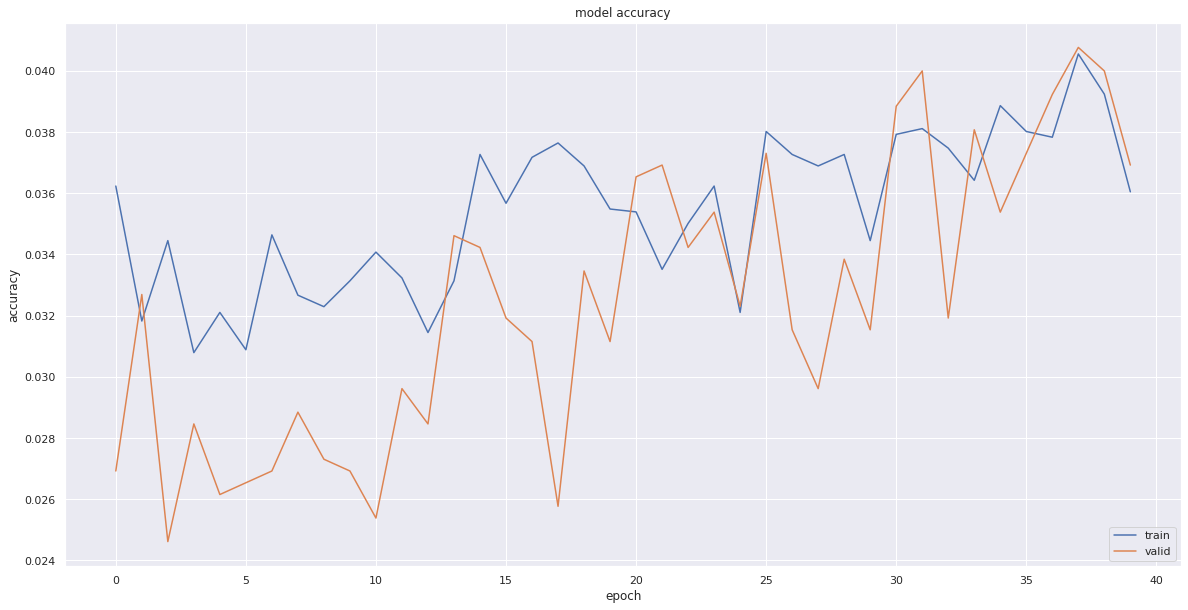

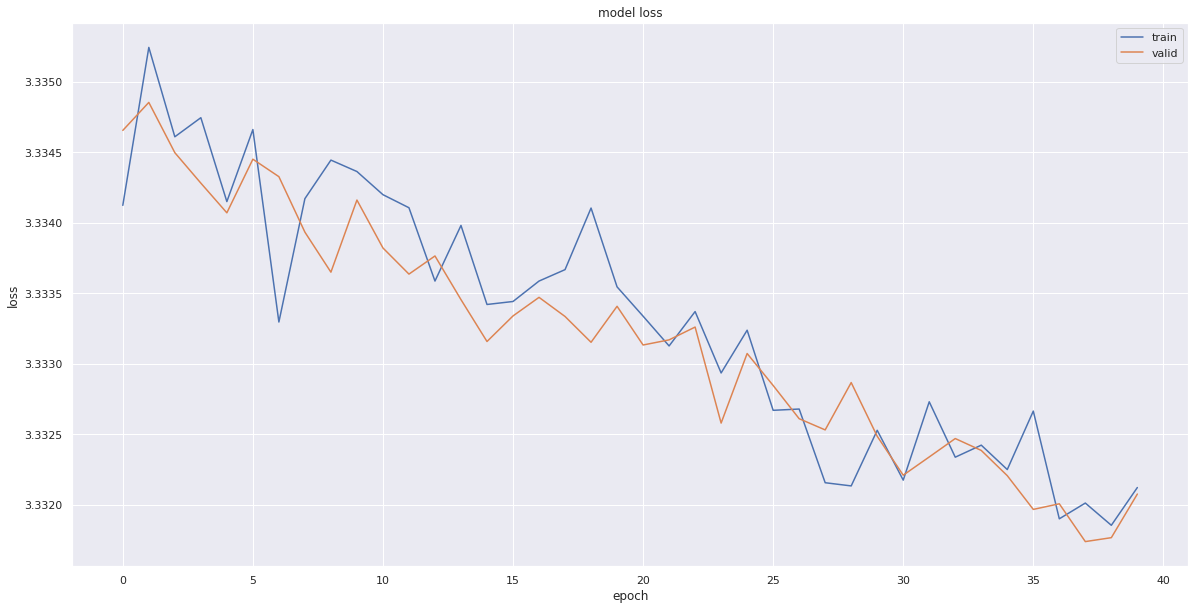

In [43]:
epochs = 40
batch_size = 100

train_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

validation_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

datagen.fit(train_data)
history = model_1.fit(
    train_generator,
    steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
    validation_data = validation_generator,
    validation_steps = len(train_data) * validation_split // batch_size,
    epochs = epochs, 
    callbacks = [tensorboard],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [34]:
#%tensorboard --logdir logs

In [44]:
print("Evaluate on test data")
result = model_1.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_1.metrics_names, result)))

Evaluate on test data
34/34 [==============================] - 0s 4ms/step - loss: 3.3315 - accuracy: 0.0384
test loss, test acc: [3.3314990997314453, 0.03839285671710968]
{'loss': 3.3314990997314453, 'accuracy': 0.03839285671710968}


## Model 2)

### Architecture
[CONV2D - MAXPOOL] [CONV2D - MAXPOOL] [DENSE - DROPOUT - DENSE]

In [36]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape = (image_size, image_size, 1)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_2.add(Flatten())  
model_2.add(Dense(64))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 activation_14 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 activation_15 (Activation)  (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

### Fit

Epoch 1/150
107/107 [==============================] - 6s 46ms/step - loss: 3.3266 - accuracy: 0.0454 - val_loss: 3.3142 - val_accuracy: 0.0531
Epoch 2/150
107/107 [==============================] - 4s 35ms/step - loss: 3.2940 - accuracy: 0.0653 - val_loss: 3.2504 - val_accuracy: 0.1058
Epoch 3/150
107/107 [==============================] - 4s 36ms/step - loss: 3.1861 - accuracy: 0.0959 - val_loss: 3.0661 - val_accuracy: 0.1492
Epoch 4/150
107/107 [==============================] - 4s 41ms/step - loss: 3.0438 - accuracy: 0.1233 - val_loss: 2.8823 - val_accuracy: 0.1758
Epoch 5/150
107/107 [==============================] - 4s 34ms/step - loss: 2.9016 - accuracy: 0.1522 - val_loss: 2.7196 - val_accuracy: 0.2058
Epoch 6/150
107/107 [==============================] - 4s 35ms/step - loss: 2.7708 - accuracy: 0.1756 - val_loss: 2.5625 - val_accuracy: 0.2458
Epoch 7/150
107/107 [==============================] - 4s 35ms/step - loss: 2.6279 - accuracy: 0.2050 - val_loss: 2.4165 - val_accuracy:

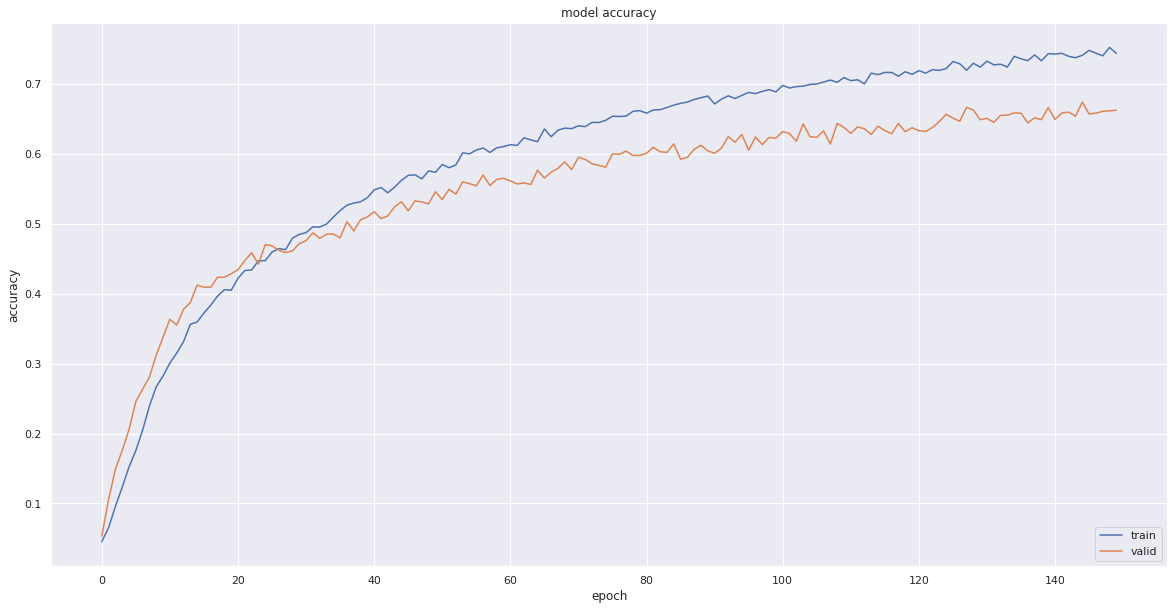

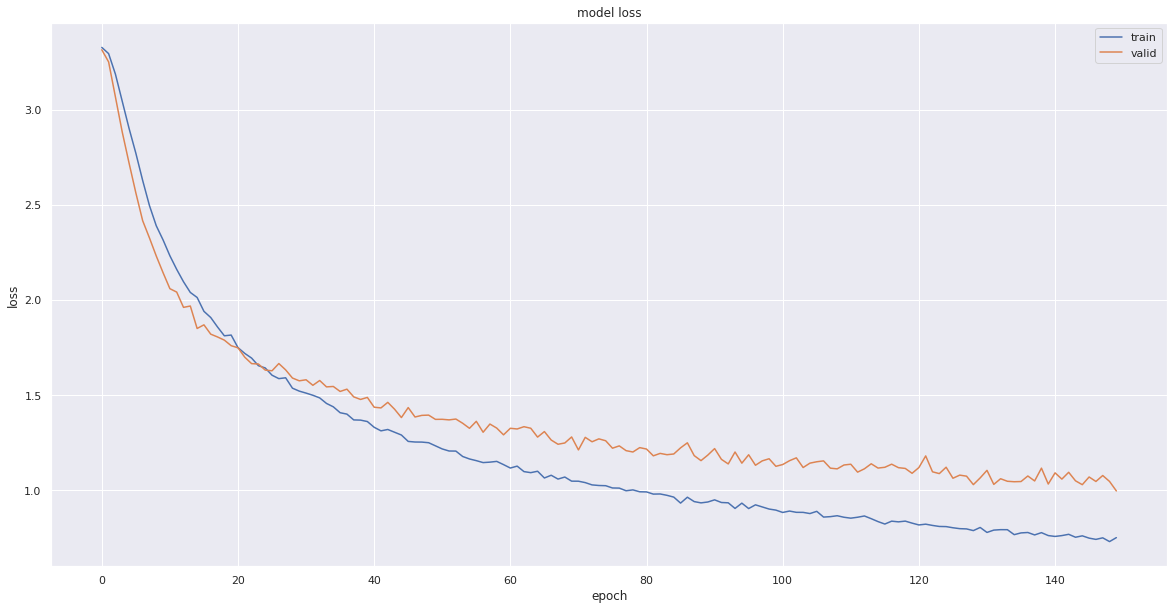

In [37]:
epochs = 150
batch_size = 100

train_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

validation_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

datagen.fit(train_data)
history = model_2.fit(
    train_generator,
    steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
    validation_data = validation_generator,
    validation_steps = len(train_data) * validation_split // batch_size,
    epochs = epochs, 
    callbacks = [tensorboard],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [38]:
print("Evaluate on test data")
result = model_2.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_2.metrics_names, result)))

Evaluate on test data
34/34 [==============================] - 0s 4ms/step - loss: 0.4476 - accuracy: 0.8503
test loss, test acc: [0.44755855202674866, 0.8502976298332214]
{'loss': 0.44755855202674866, 'accuracy': 0.8502976298332214}


## Model 2) Modifications increasing `learning_rate`. 

### Architecture

In [39]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_2_2 = tf.keras.Sequential()
model_2_2.add(Conv2D(32, (3, 3), padding='same', input_shape = (image_size, image_size, 1)))
model_2_2.add(Activation('relu'))
model_2_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2_2.add(Conv2D(32, (3, 3)))
model_2_2.add(Activation('relu'))
model_2_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2_2.add(Conv2D(64, (3, 3)))
model_2_2.add(Activation('relu'))
model_2_2.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_2_2.add(Flatten())  
model_2_2.add(Dense(64))
model_2_2.add(Activation('relu'))
model_2_2.add(Dropout(0.5))
model_2_2.add(Dense(num_classes))
model_2_2.add(Activation('softmax'))

model_2_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_2_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 activation_19 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 activation_20 (Activation)  (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

### Fit

Epoch 1/150
107/107 [==============================] - 4s 37ms/step - loss: 3.1062 - accuracy: 0.0965 - val_loss: 2.5500 - val_accuracy: 0.2496
Epoch 2/150
107/107 [==============================] - 4s 35ms/step - loss: 2.2738 - accuracy: 0.2970 - val_loss: 1.8801 - val_accuracy: 0.3862
Epoch 3/150
107/107 [==============================] - 4s 34ms/step - loss: 1.7860 - accuracy: 0.4103 - val_loss: 1.5963 - val_accuracy: 0.4808
Epoch 4/150
107/107 [==============================] - 4s 35ms/step - loss: 1.5176 - accuracy: 0.4901 - val_loss: 1.4979 - val_accuracy: 0.5012
Epoch 5/150
107/107 [==============================] - 4s 40ms/step - loss: 1.3235 - accuracy: 0.5502 - val_loss: 1.4237 - val_accuracy: 0.5292
Epoch 6/150
107/107 [==============================] - 4s 40ms/step - loss: 1.1764 - accuracy: 0.6006 - val_loss: 1.2779 - val_accuracy: 0.5831
Epoch 7/150
107/107 [==============================] - 4s 42ms/step - loss: 1.0897 - accuracy: 0.6354 - val_loss: 1.2982 - val_accuracy:

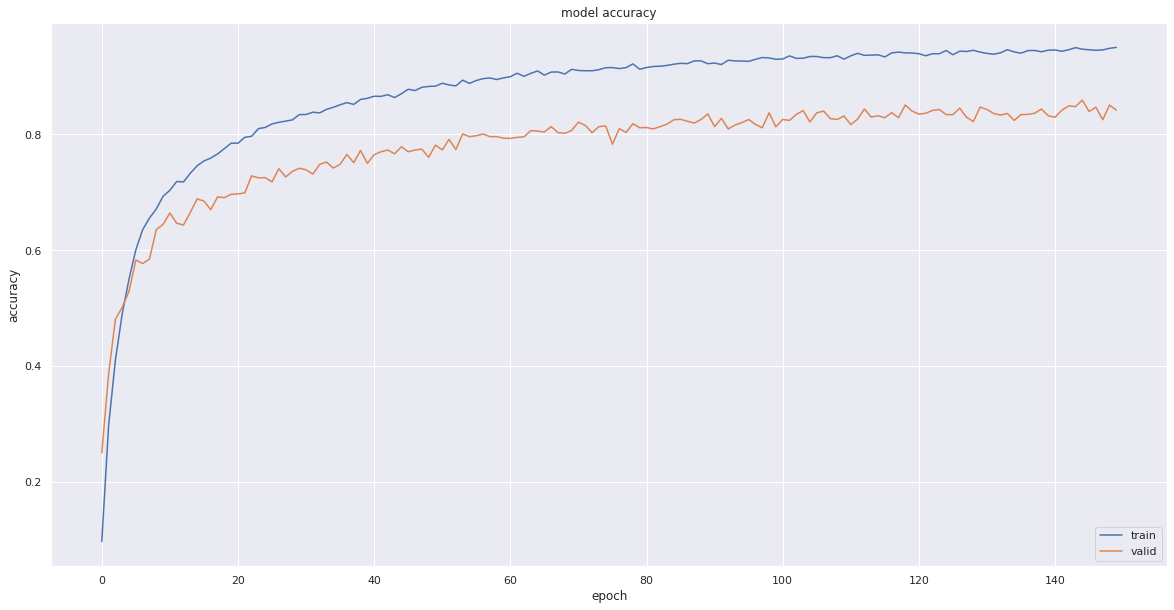

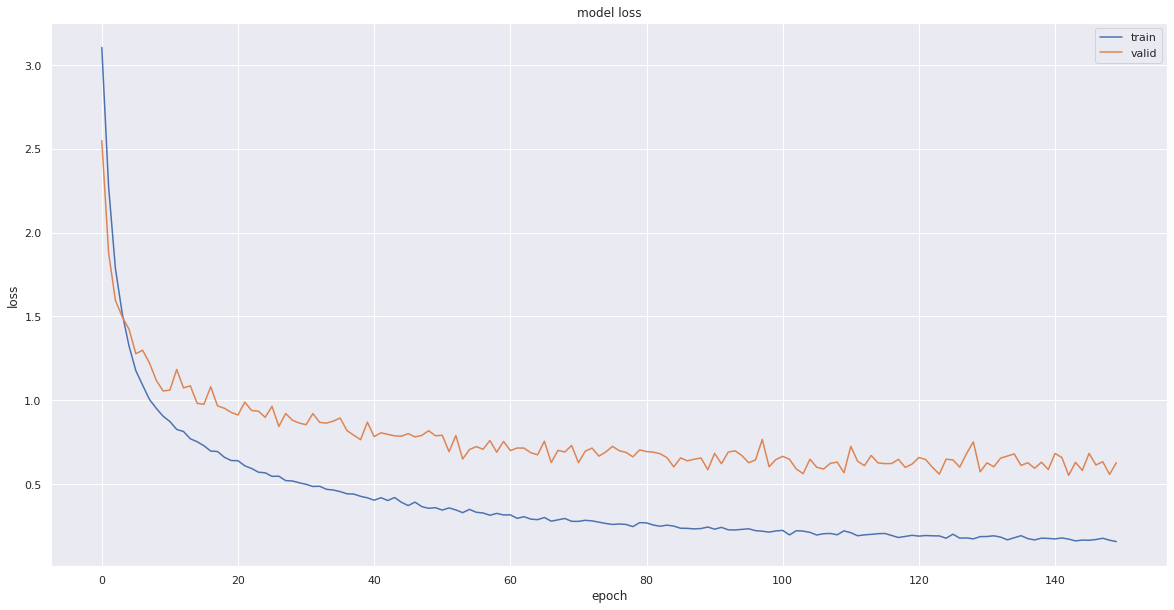

In [40]:
epochs = 150
batch_size = 100

train_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

validation_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

datagen.fit(train_data)
history = model_2_2.fit(
    train_generator,
    steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
    validation_data = validation_generator,
    validation_steps = len(train_data) * validation_split // batch_size,
    epochs = epochs, 
    callbacks = [tensorboard],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [41]:
print("Evaluate on test data")
result = model_2_2.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_2_2.metrics_names, result)))

Evaluate on test data
34/34 [==============================] - 0s 3ms/step - loss: 0.2303 - accuracy: 0.9500
test loss, test acc: [0.2303180992603302, 0.949999988079071]
{'loss': 0.2303180992603302, 'accuracy': 0.949999988079071}


## Evaluation and Post-Processing


### Visualiasing ConvNet lern

In [45]:
!pip install opencv-python

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2

# Local path to the target image
img_path = './african-elephant.jpg'
image_orig = cv2.imread(img_path)
print(image_orig.shape)

# Python Imaging Library (PIL) image of size 224x224
img = image.load_img(img_path, target_size=(224,224))

# float32 Numpy array of shape (224,224,3)
x = image.img_to_array(img)

# Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
print(x.shape)

# Preprocess the batch (this does activation-map-wise color normalization)
x = preprocess_input(x)

### Classification Report
After calculating three different models, we can conclude, that model `model_2_2` performs best, with an overall score of 0.95. We are going now that have a closer look at this model. 

In [3]:
test_labels

NameError: ignored

In [ ]:
num_classes = len(test_label)
target_names = test_labels
# Create classification report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names = target_names))

### Benchmark
https://paperswithcode.com/sota/image-classification-on-mnist

### Cross-Validation

# Final Words 